In [1]:
import os
import re
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import string
from collections import Counter
from wordcloud import WordCloud

import spacy
from spacy import displacy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


False

In [3]:
data_dir = "../data/MACCROBAT"

We have a total of 200 .txt files along with their corresponding 200 .ann files.

**Importance of Converting .ann Files to BIO Format for Named Entity Recognition (NER):**

To perform named entity recognition (NER) using annotated data in the .ann format, we need to convert the annotation files into the BIO format.

The BIO format is a widely used format for representing annotated text data for NER. In this format, each token in the text is assigned a label that indicates whether it is part of a named entity or not. The labels follow a prefix notation where the letter 'B' indicates the beginning of a named entity, 'I' indicates the continuation of a named entity, and 'O' indicates that the token is not part of a named entity.

To convert .ann files to BIO format, we can extract the text and the annotations from the .ann files and then iterate through each token in the text. For each token, we check if it overlaps with any of the annotated entities. If it does, we assign the appropriate BIO label based on the position of the token in the named entity (beginning, inside, or outside).

Once we have converted the .ann files to BIO format, we can use them to train and evaluate NER models.

**Below is the example of bio format file**

| Word   | Tag   |
|--------|-------|
| Patient| B-PER |
| has    | O     |
| diabetes | B-DIS |
| type   | I-DIS |
| 2      | I-DIS |
| and    | O     |
| high   | B-DIS |
| blood  | I-DIS |
| pressure | I-DIS |
| .      | O     |


**Importance of EDA before the conversion process**

Before converting .ann files to the BIO format, it is important to perform exploratory data analysis (EDA) on both the annotation and text files. This is necessary to ensure that the data is consistent and error-free, which can affect the quality of the NER model we build.

During EDA, we can check for inconsistencies or errors in the annotation files such as missing or overlapping entities, incorrect entity types, and inconsistent entity boundaries. We can also check the quality and completeness of the text data, such as missing or duplicated text, spelling errors, or formatting issues.

By performing EDA, we can identify and address any data quality issues before proceeding with the conversion process. This can improve the accuracy and reliability of our NER model and ensure that it produces high-quality results.

## Loading Data

### Step 1 - Getting doc ids 

In [4]:
def get_doc_ids(data_dir):
    """
    Extracts unique document IDs from a directory of files.

    Args:
        data_dir (str): Path to the directory containing the files.

    Returns:
        list: A list of unique document IDs (strings) found in the directory.

    Raises:
        OSError: If the specified directory does not exist or cannot be accessed.
        ValueError: If no files with the expected naming convention are found in the directory.
    """
    if not os.path.exists(data_dir):
        raise OSError(f"Directory {data_dir} does not exist.")
    
    doc_ids = []
    for doc in os.listdir(data_dir):
        doc_id = doc.split(".")[0]
        if doc_id not in doc_ids:
            doc_ids.append(doc_id)

    if not doc_ids:
        raise ValueError(f"No files with expected naming convention found in {data_dir}.")
    
    return doc_ids


In [5]:
doc_ids = get_doc_ids(data_dir)
print(f"Number of documents is {len(doc_ids)}")

Number of documents is 200


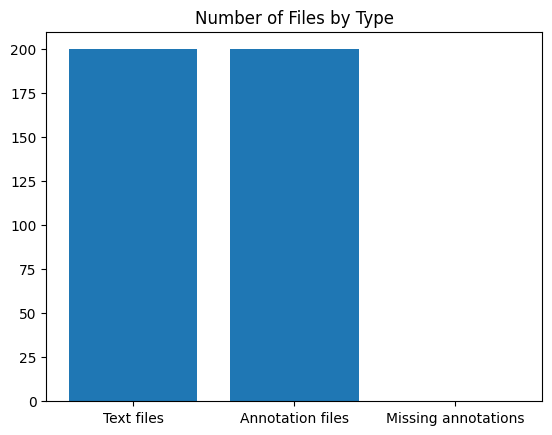

In [6]:
text_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
ann_files = [f for f in os.listdir(data_dir) if f.endswith('.ann')]

text_ids = [f.split('.')[0] for f in text_files]
ann_ids = [f.split('.')[0] for f in ann_files]

# count number of files without annotations
missing_anns = 0
for text_id in text_ids:
    if text_id not in ann_ids:
        missing_anns += 1

# create bar chart
labels = ['Text files', 'Annotation files', 'Missing annotations']
counts = [len(text_files), len(ann_files), missing_anns]

plt.bar(labels, counts)
plt.title('Number of Files by Type')
plt.show()


## Step 2: Load the .txt files

In [7]:
import os

def load_txt_data(txt_dir, doc_ids):
    """
    Loads text data from a directory of .txt files into a dictionary.

    Args:
        txt_dir: Path to the directory containing the .txt files.
        doc_ids: A list of file IDs (strings) to load from the directory.

    Returns:
        A dictionary of file IDs (strings) mapped to their corresponding data, 
        where each data item is represented by a nested dictionary containing the following key-value pairs:
            - "text": the full text of the file as a string.
            - "annotations": an empty list to be used for annotations on the file.

    Raises:
        OSError: If the specified directory does not exist or cannot be accessed.
        ValueError: If no .txt files are found in the directory.
    """
    if not os.path.exists(txt_dir):
        raise OSError(f"Directory {txt_dir} does not exist.")

    data = {}
    
    for file_id in doc_ids:
        
        file_name = file_id + ".txt"
        
        with open(os.path.join(txt_dir, file_name), "r") as f:
            text = f.read()
            
        data[file_id] = {
                "text": text, 
                "annotations": []
        }

    if not data:
        raise ValueError(f"No .txt files found in {txt_dir}.")

    return data

In [8]:
data = load_txt_data(data_dir, doc_ids)
print("data: {")
for doc_id in list(data.keys())[:3]:
    print(f"\t'{doc_id}': {{")
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"\t\ttext:\t{text[:78]} .....")
    print(f"\t\tannotations: {annotations}")
    print("\t},")
print('\t....')
print("}")

data: {
	'19860925': {
		text:	Our 24-year-old non-smoking male patient presented with repeated hemoptysis in .....
		annotations: []
	},
	'26361640': {
		text:	A 68-year-old female nonsmoker, nondrinker with a medical history of hypertens .....
		annotations: []
	},
	'26228535': {
		text:	A 25-year-old female patient had noticed left-sided visual loss and amenorrhea .....
		annotations: []
	},
	....
}


#### Document Length Distribution

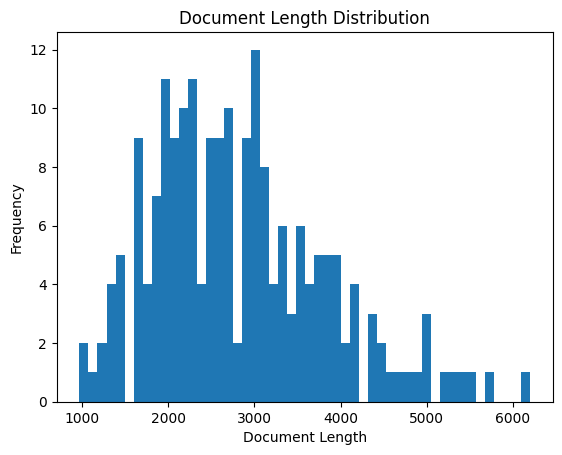

In [9]:
def get_doc_length_distribution(data):
    """
    Computes the document length distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        list: A list of document lengths (integers).
    """
    
    doc_lengths = []
    for doc_id in data:
        
            text = data[doc_id]['text']
            
            doc_length = len(text)
            doc_lengths.append(doc_length)
    
    return doc_lengths


doc_lengths = get_doc_length_distribution(data)

# plot the document length distribution
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()

#### Sentence Count Distribution

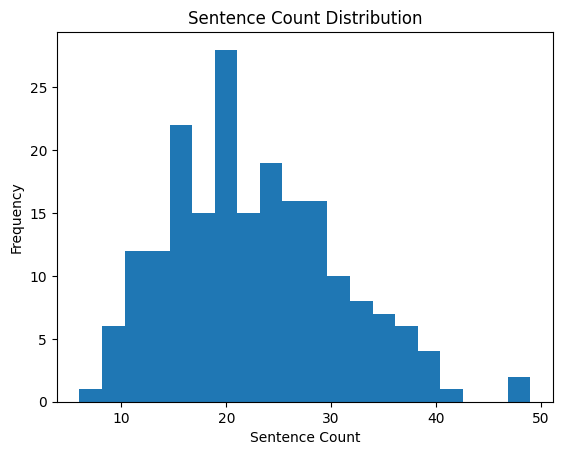

In [10]:
def get_doc_sentence_counts(data):
    """
    Computes the number of sentences in each document.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        list: A list of sentence counts (integers) for each document.
    """
    
    sentence_counts = []
    for doc_id in data:
        text = data[doc_id]['text']
        sentences = nltk.sent_tokenize(text)
        sentence_count = len(sentences)
        sentence_counts.append(sentence_count)
    
    return sentence_counts

# get the sentence counts
sentence_counts = get_doc_sentence_counts(data)

# plot the sentence count distribution
plt.hist(sentence_counts, bins=20)
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.title("Sentence Count Distribution")
plt.show()


#### Word Frequency Distribution

In [11]:
def get_word_frequency_distribution(data):
    """
    Computes the word frequency distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        dict: A dictionary where the keys are words and the values are their frequency counts.
    """
    
    # Load stop words
    stop_words = set(stopwords.words('english'))
    
    # Tokenize text and count word frequency
    all_words = []
    for doc_id in data:
        text = data[doc_id]['text']
        words = nltk.word_tokenize(text)
        words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
        all_words.extend(words)
        
    word_freq = dict(Counter(all_words))
    
    return word_freq

def plot_word_freq_distribution(word_freq):
    """
    Plots the word frequency distribution.

    Args:
        word_freq (dict): A dictionary where the keys are words and the values are their frequency counts.
    """

    # sort the word frequencies in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # extract the word and frequency lists from the sorted word frequency tuples
    words, freqs = zip(*sorted_word_freq)

    # plot the word frequency distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), freqs)

    plt.ylabel('Frequency')
    plt.title('Word Frequency Distribution')
    plt.show()



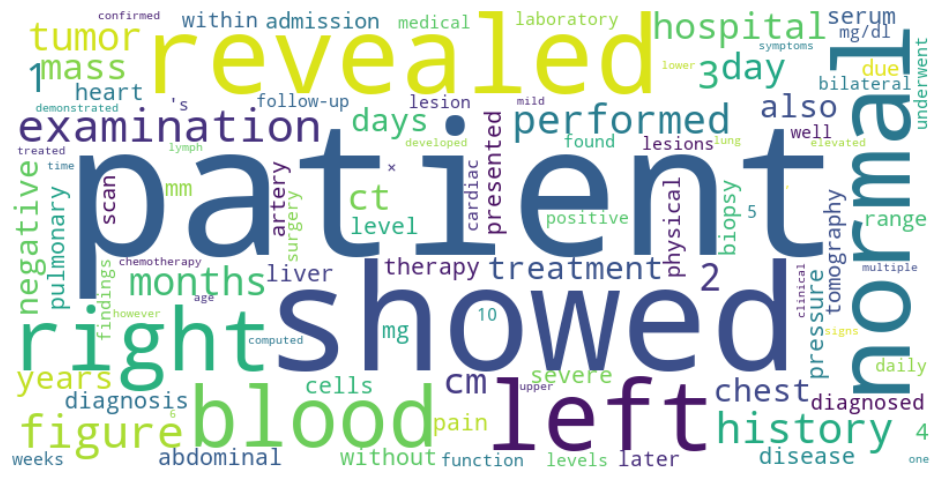

In [13]:

def get_word_frequencies(data):
    """
    Computes the word frequency distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        FreqDist: A frequency distribution object from the nltk.probability module.
    """
    
    word_freq = FreqDist()
    stop_words = set(stopwords.words('english'))
    for doc_id in data:
        text = data[doc_id]['text']
        tokens = word_tokenize(text)
        
        # Remove stopwords and punctuation
        clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in string.punctuation]
        
        # Update word frequency distribution
        word_freq.update(clean_tokens)
    
    return word_freq

def plot_wordcloud(word_freq):
    """
    Plots a wordcloud of the word frequency distribution.

    Args:
        word_freq (FreqDist): A frequency distribution object from the nltk.probability module.
    """
    
    wc = WordCloud(background_color='white', max_words=100, width=800, height=400)
    wc.generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
word_freq = get_word_frequencies(data)
plot_wordcloud(word_freq)

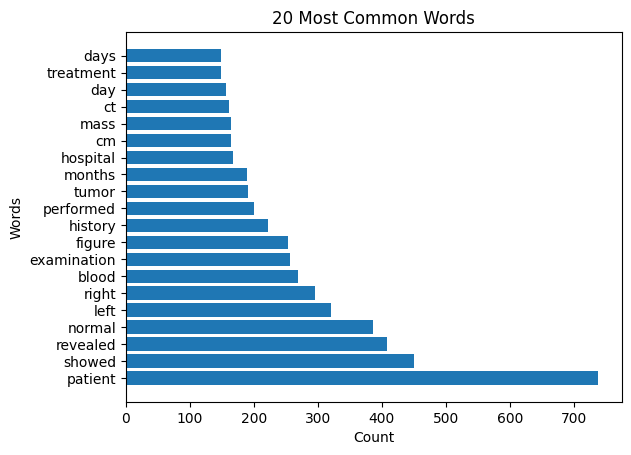

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import collections


stop_words = set(stopwords.words('english'))

all_words = []
for doc_id in data:
    text = data[doc_id]['text']
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    all_words.extend(words)
    
# Get the word frequency distribution
word_freq = Counter(all_words)
# Remove stop words
for stop_word in stop_words:
    del word_freq[stop_word]


# Get the 20 most common words
most_common = word_freq.most_common(20)

# Create a horizontal bar chart
words = [word[0] for word in most_common]
counts = [word[1] for word in most_common]
plt.barh(words, counts)

# Add labels and title
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("20 Most Common Words")

plt.show()

#### Non-ASCII Characters

In [14]:
non_ascii_characters = []
# Loop through each file in the folder
for doc_id in doc_ids:
    # Check if the file is a .txt file
    filename = f"{doc_id}.txt"
    # Open the file
    with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
        # Read the file content
        file_content = file.read()
        # Find all non-ASCII characters using regular expressions
        non_ascii_chars = re.findall(r'[^\x00-\x7F]', file_content)
        # Print the filename and the special characters found
        if non_ascii_chars: 
            print(f'File: {filename}, Non-ASCII characters: {non_ascii_chars}')        
        non_ascii_characters.extend(non_ascii_chars)

File: 19860925.txt, Non-ASCII characters: ['×', '\u200b', '\u200b']
File: 26361640.txt, Non-ASCII characters: ['μ', 'μ', '\u200b', '’']
File: 26228535.txt, Non-ASCII characters: ['μ', '–', '’']
File: 23678274.txt, Non-ASCII characters: ['µ', 'µ', 'µ', 'µ']
File: 25853982.txt, Non-ASCII characters: ['×']
File: 28103924.txt, Non-ASCII characters: ['–', '–', '–', '’', '’', '’', '–', '’']
File: 27064109.txt, Non-ASCII characters: ['×', '–', '–', '–', 'μ', '–', '–', '’', '’', 'β', 'λ', '’', 'β']
File: 20146086.txt, Non-ASCII characters: ['–', '–']
File: 28353558.txt, Non-ASCII characters: ['γ', '\u200a']
File: 22515939.txt, Non-ASCII characters: ['\u200b']
File: 28353588.txt, Non-ASCII characters: ['×', '×', '\u200a', '\u200a', '\u200a', '×', '\u200a', '\u200a', '×', '\u200a', '\u200a', '–', '\u200a', '\u200a', '–']
File: 26309459.txt, Non-ASCII characters: ['µ', 'µ']
File: 28272235.txt, Non-ASCII characters: ['’', '\u200a', '\u200a', '×', '\u200a', '–', '\u200a', '×', '\u200a', '\u200a', '

In [15]:
', '.join(set(non_ascii_characters))

'≥, λ, ü, α, κ, \u2005, Ⅱ, γ, ö, \u200a, ®, ℃, ”, ≤, ∼, δ, ™, π, ×, \u200b, −, μ, ・, —, é, “, ‘, ½, µ, °, ɤ, €, ∗, –, ′, ’, β, \u2009'

#### Transliterate non-ASCII characters to their closest ASCII equivalents.

In [19]:
from unidecode import unidecode

for char in set(non_ascii_characters):
    print(f"{char}  {unidecode(char)}")

∗  *
€  EUR
™  (tm)
κ  k
—  --
Ⅱ  II
“  "
    
’  '
α  a
π  p
γ  g
ü  u
°  deg
・  
δ  d
≤  <=
​   
β  b
–  -
    
é  e
    
∼  ~
×  x
ɤ  u
≥  >=
℃  
ö  o
µ  u
”  "
½   1/2
‘  '
′  '
®  (r)
−  -
μ  m
λ  l


## Step 3 - Load the ann files

### 3 - a Checking structure of .ann files

In [20]:
sample_ann_file = doc_id + ".ann"
lines = []
with open(os.path.join(data_dir, sample_ann_file)) as f:
    for line in f.readlines():
        lines.append(line)
print("")
for line in lines[:6]:
    print(line.strip())


T1	Age 2 13	64 year old
T2	Sex 14 20	female
T3	Disease_disorder 31 34	HHT
E1	Disease_disorder:T3
#1	AnnotatorNotes E1	Hereditary hemorrhagic telangiectasia
T4	Clinical_event 38 46	referred


All the 200 .ann files are in brat standoff format

**General annotation structure**

All annotations follow the same basic structure: Each line contains one annotation, and each annotation is given an ID that appears first on the line, separated from the rest of the annotation by a single TAB character. The rest of the structure varies by annotation type.

By looking at the first few lines of one of the .ann files, we can see the format followed is as follows

Annotation_ID [TAB] Entity Start End [TAB] Token

This format is a variation of the BRAT standoff format, where each line represents a single annotation. 
Here's what each of the fields represent:

* Annotation_ID: A unique identifier for the annotation, typically a string or number.
* Entity: The type of entity being annotated, such as "person", "location", "organization", etc.
* Start: The starting position of the annotated entity within the original text, typically measured in character offsets.
* End: The ending position of the annotated entity within the original text, also measured in character offsets.
* Token: The actual text of the annotated entity, represented as a single token or a sequence of tokens.


**Annotation ID conventions**

All annotations IDs consist of a single upper-case character identifying the annotation type and a number. 

The initial ID characters relate to annotation types as follows:

* T: text-bound annotation
* R: relation
* E: event
* A: attribute
* M: modification (alias for attribute, for backward compatibility)
* N: normalization [new in v1.3]
* #: note

**Question 1:** <span style="color:blue">Do all these annotation IDs needed for NER task?</span>

**Entity annotations**

Each entity annotation has a unique ID and is defined by type (e.g. Person or Organization) and the span of characters containing the entity mention (represented as a "start end" offset pair).

**Question 2:** <span style="color:blue">Does the entity annotation followed by single "start end" offset pair or more than one "start end" offset pairs?</span>

**Token strucuture**

The actual text of the annotated entity, represented as a single token or a sequence of tokens.

**Question 3:** <span style="color:blue">Number of annotated token with more than one words and what are all the possible separators ?</span>

### 3 - b  Checking all the annotation IDs in all .ann files

In [21]:
tags = []

for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            tags.append(line.split("\t")[0][0])
                
set(tags)

{'#', '*', 'A', 'E', 'R', 'T'}

**Question 1:** <span style="color:blue">Do all these annotation IDs needed for NER task?</span>

**Annotation IDs needed for NER task**

To generate the BIO format for named entity recognition, only the T tags are needed. The T tags represent annotations for named entities in the text. Specifically, we need to identify the start and end positions of each named entity and assign it a label indicating the type of entity it is.

For named entity recognition, only the T tags are needed to generate the BIO format. 

The other tags such as #, *, A, E, and R are used for representing different types of information in the .ann files and are not directly related to named entity recognition.

* \# is used to denote comments in the annotation file.
* \* is used to represent coreference annotations.
* A is used to represent attribute annotations.
* E is used to represent event annotations.
* R is used to represent relation annotations.

Therefore, we can ignore all other tags except for the T tags when generating the BIO format for named entity recognition.

**Question 2:** <span style="color:blue">Does the entity annotation followed by single "start end" offset pair or more than one "start end" offset pairs?</span>

In [22]:
flag = False
for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            if line.startswith('T'):
                label = line.split('\t')[1].split()[0]
                start_end_pair = line.split('\t')[1].split()[1:]
                if len(start_end_pair) > 2:
                    print('There exists more than one start end offset pairs')
                    print(' '.join(start_end_pair))


There exists more than one start end offset pairs
701 714;730 735
There exists more than one start end offset pairs
4085 4093;4103 4108
There exists more than one start end offset pairs
3117 3124;3135 3141
There exists more than one start end offset pairs
2552 2559;2585 2654
There exists more than one start end offset pairs
704 715;721 726
There exists more than one start end offset pairs
828 835;861 879
There exists more than one start end offset pairs
849 857;861 879
There exists more than one start end offset pairs
341 350;357 358
There exists more than one start end offset pairs
315 317;319 330
There exists more than one start end offset pairs
297 313;319 330
There exists more than one start end offset pairs
606 621;641 647
There exists more than one start end offset pairs
1017 1032;1052 1058
There exists more than one start end offset pairs
1316 1318;1328 1336
There exists more than one start end offset pairs
1386 1391;1408 1412
There exists more than one start end offset pairs
60

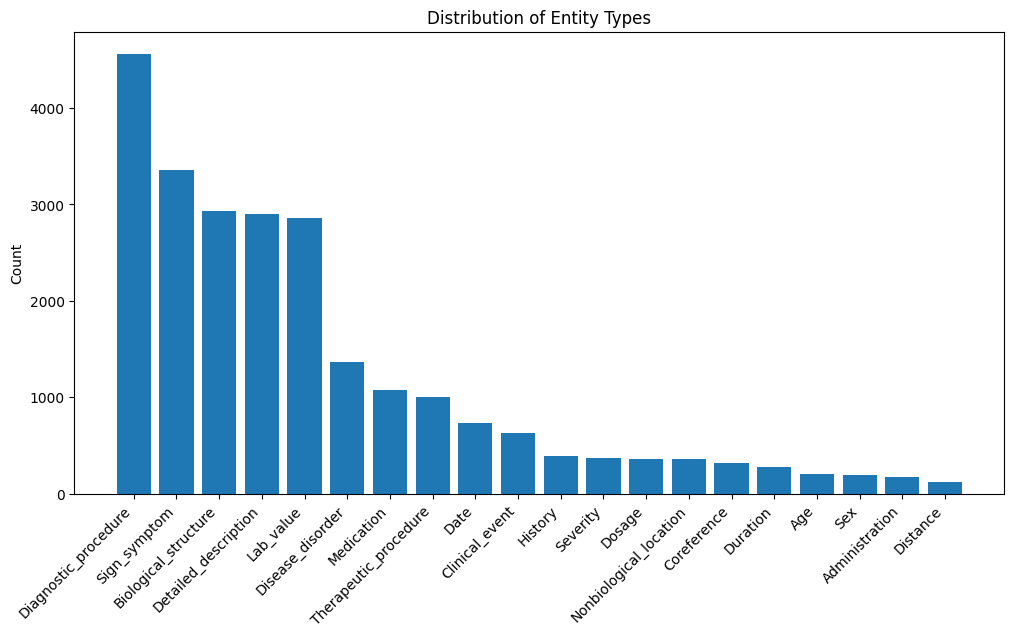

In [23]:
entity_type_counts = {}
for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f:
            if line.startswith("T"):
                entity_type = line.split()[1]
                entity_type_counts[entity_type] = entity_type_counts.get(entity_type, 0) + 1

entity_types = list(entity_type_counts.keys())
counts = list(entity_type_counts.values())

# sort by count in descending order
entity_types_sorted = [x for _, x in sorted(zip(counts, entity_types), reverse=True)]
counts_sorted = sorted(counts, reverse=True)

# only keep top 20 entities for visualization
entity_types_top = entity_types_sorted[:20]
counts_top = counts_sorted[:20]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(entity_types_top, counts_top)
ax.set_xticks(range(len(entity_types_top)))
ax.set_xticklabels(entity_types_top, rotation=45, ha="right")
ax.set_ylabel("Count")
ax.set_title("Distribution of Entity Types")
plt.show()


**Question 3:** <span style="color:blue">Number of annotated token with more than one words and what are all the possible separators ?</span>

After taking look at all the tokens, 

possible separators are 

* space
* \u200a: a Unicode character that represents the hair space.
* different forms of hyphens and dashes:
    * -: This is the regular hyphen or minus sign character.
    * \u2010: This is the hyphen character.
    * \u2011: This is the non-breaking hyphen character.
    * \u2012: This is the figure dash character.
    * \u2013: This is the en dash character.
    * \u2014: This is the em dash character.
    * \u2015: This is the horizontal bar character.
    * \u2212: This is the minus sign character.
    * \uff0d: This is the fullwidth hyphen-minus character.

### 3 - c Split when annotated token is a sequence of tokens.

In [24]:
def splitting_tokens(file_id, start, end, hyphen_split=True):
    """
    Splits a token into its constituent words and returns a list of tokens along with the corresponding
    ranges for each word in the original text.

    Args:
        text (str): The original text containing the token to be split.
        start (int): The starting index of the token in the text.
        end (int): The ending index of the token in the text.

    Returns:
        A tuple containing:
            - a list of the constituent words of the token
            - a list of lists containing the start and end indices of each word in the original token
    """
    text = data[file_id]['text']
    token = text[start:end]

    extra_sep = ['\u200a']
    if hyphen_split:
        extra_sep += ['-', '\u2010', '\u2011', '\u2012', '\u2013', '\u2014', '\u2015', '\u2212', '\uff0d']

    new_range = []
    tokens = []

    curr = start
    new_start = None

    for c in token + " ":
        if c.isspace() or c in extra_sep:
            if new_start:
                new_range.append([new_start, curr])
                tokens.append(text[new_start:curr])
                new_start = None
        elif not new_start:
            new_start = curr
        curr += 1

    return tokens, new_range


### 3 - d Load ann data

In [25]:
def load_ann_data(ann_dir, doc_ids, data, hyphen_split=True):
    """
    Loads annotations from a directory of .ann files and adds them to the corresponding 
    files in a data dictionary.

    Args:
        ann_dir (str): Path to the directory containing the .ann files.
        data (dict): A dictionary of file IDs (strings) mapped to their corresponding data, 
        where each data item is represented by a nested dictionary containing the following key-value pairs:
            - "text": the full text of the file as a string.
            - "annotations": a list of annotations for the file, where each annotation is represented 
            by a dictionary containing the following key-value pairs:
                - "label": the label of the annotation as a string.
                - "start": the starting character index of the annotation as an integer.
                - "end": the ending character index of the annotation as an integer.

    Returns:
        data - modified the input dictionary
    """
    for doc_id in doc_ids:

        file_name = doc_id + ".ann"
        
        with open(os.path.join(ann_dir, file_name), "r") as f:

            annotations = []

            for line in f:
                if line.startswith("T"):
                    fields = line.strip().split("\t")
                    if len(fields[1].split(" ")) > 1:
                        label = fields[1].split(" ")[0]

                        # Extracting start end indices (Few annotations contain more than one disjoint ranges)
                        start_end_range = [
                            list(map(int, start_end.split()))
                            for start_end in ' '.join(fields[1].split(" ")[1:]).split(';')
                        ]

                        start_end_range_fixed = []
                        for start, end in start_end_range:
                            tokens, start_end_split_list = splitting_tokens(doc_id, start, end,
                                                                                  hyphen_split)
                            start_end_range_fixed.extend(start_end_split_list)

                        # Adding labels, start, end to annotations
                        for start, end in start_end_range_fixed:
                            annotations.append({
                                "label": label,
                                "start": start,
                                "end": end
                            })
            # sort annotations based on 'start' key before adding it to our dataset
            annotations = sorted(annotations, key=lambda x: (x['start'], x['label']))
            data[doc_id]["annotations"] = annotations
                
    return data

**Loading Data into _data_ dictionary**

In [26]:
data = load_ann_data(data_dir, doc_ids, data)

**Looking at the _data_ dictionary**

In [27]:
for doc_id in list(data.keys())[:3]:
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"text:\n{text[:40]} .....")
    print(f"annotations:\n{annotations[:2]} .....")

text:
Our 24-year-old non-smoking male patient .....
annotations:
[{'label': 'Age', 'start': 4, 'end': 6}, {'label': 'Age', 'start': 7, 'end': 11}] .....
text:
A 68-year-old female nonsmoker, nondrink .....
annotations:
[{'label': 'Age', 'start': 2, 'end': 4}, {'label': 'Age', 'start': 5, 'end': 9}] .....
text:
A 25-year-old female patient had noticed .....
annotations:
[{'label': 'Age', 'start': 2, 'end': 4}, {'label': 'Age', 'start': 5, 'end': 9}] .....


Successfully loaded data into dictionary which is in the below format

```
data : {

    'file_id': {
    
        'text': text_data,
        'annotations': [
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        ....
                       ],
    'file_id': {
    
        'text': text_data,
        'annotations': [
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        {'label': label, 'start': start, 'end': end},
                        ....
                       ],
    
    },
    
    ......

}
```

In [158]:
entities = set()
for doc_id, doc in data.items():
    for ann in doc['annotations']:
        entities.add(ann['label'])
entities

{'Activity',
 'Administration',
 'Age',
 'Area',
 'Biological_attribute',
 'Biological_structure',
 'Clinical_event',
 'Color',
 'Coreference',
 'Date',
 'Detailed_description',
 'Diagnostic_procedure',
 'Disease_disorder',
 'Distance',
 'Dosage',
 'Duration',
 'Family_history',
 'Frequency',
 'Height',
 'History',
 'Lab_value',
 'Mass',
 'Medication',
 'Nonbiological_location',
 'Occupation',
 'Other_entity',
 'Other_event',
 'Outcome',
 'Personal_background',
 'Qualitative_concept',
 'Quantitative_concept',
 'Severity',
 'Sex',
 'Shape',
 'Sign_symptom',
 'Subject',
 'Texture',
 'Therapeutic_procedure',
 'Time',
 'Volume',
 'Weight'}

In [159]:

colors = {"Activity": "#f9d5e5", 
          "Administration": "#f7a399", 
          "Age": "#f6c3d0",
          "Area": "#fde2e4",
          "Biological_attribute": "#d5f5e3",
          "Biological_structure": "#9ddfd3",
          "Clinical_event": "#77c5d5",
          "Color": "#a0ced9",
          "Coreference": "#e3b5a4",
          "Date": "#f1f0d2",
          "Detailed_description": "#ffb347",
          "Diagnostic_procedure": "#c5b4e3",
          "Disease_disorder": "#c4b7ea",
          "Distance": "#bde0fe",
          "Dosage": "#b9e8d8",
          "Duration": "#ffdfba",
          "Family_history": "#e6ccb2",
          "Frequency": "#e9d8a6",
          "Height": "#f2eecb",
          "History": "#e2f0cb",
          "Lab_value": "#f4b3c2",
          "Mass": "#f4c4c3",
          "Medication": "#f9d5e5",
          "Nonbiological_location": "#f7a399",
          "Occupation": "#f6c3d0",
          "Other_entity": "#d5f5e3",
          "Other_event": "#9ddfd3",
          "Outcome": "#77c5d5",
          "Personal_background": "#a0ced9",
          "Qualitative_concept": "#e3b5a4",
          "Quantitative_concept": "#f1f0d2",
          "Severity": "#ffb347",
          "Sex": "#c5b4e3",
          "Shape": "#c4b7ea",
          "Sign_symptom": "#bde0fe",
          "Subject": "#b9e8d8",
          "Texture": "#ffdfba",
          "Therapeutic_procedure": "#e6ccb2",
          "Time": "#e9d8a6",
          "Volume": "#f2eecb",
          "Weight": "#e2f0cb"}

In [160]:
# Load the small English model
nlp = spacy.load("en_core_web_sm", disable=['ner'])

for doc_id, doc in data.items():
    text = doc['text']
    annotations = doc['annotations']


    # Create a Doc object from the text
    doc = nlp(text)
    prev_end = -1
    # Add your custom annotations to the Doc object
    for ann in annotations:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
    
    
    options = {"compact": True, "bg": "#F8F8F8",
           "ents": list(colors.keys()), 
           "colors": colors}

    # Generate the HTML visualization
    html = displacy.render(doc, style="ent", options=options)
    break


In [71]:
def create_html_doc_visualziation(html_file_dir="../html_files"):
    
    if os.path.exists(html_file_dir):
        # Delete the contents of the directory
        shutil.rmtree(html_file_dir)
    # Recreate the directory
    os.makedirs(html_file_dir)

    # Load the small English model
    nlp = spacy.load("en_core_web_sm", disable=['ner'])

    # Define the HTML template
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>{doc_id} Visualization</title>
    </head>
    <body>
        <h1>{doc_id} Visualization</h1>
        <p><a href="main.html">Back to Main Page</a></p>
        {displacy_output}
    </body>
    </html>
    """
    
    for doc_id, doc in data.items():
        text = doc['text']
        annotations = doc['annotations']


        # Create a Doc object from the text
        doc = nlp(text)
        prev_end = -1
        # Add your custom annotations to the Doc object
        for ann in annotations:
            label = ann["label"]
            start = ann["start"]
            end = ann["end"]
            if start > prev_end:
                span = doc.char_span(start, end, label=label)
                if span is not None:
                    doc.ents += tuple([span])
            prev_end = end


        options = {"compact": True, "bg": "#F8F8F8",
               "ents": list(colors.keys()), 
               "colors": colors,
                "collapse_punct": False}

        # Generate the HTML visualization
        html = displacy.render(doc, style="ent", options=options, jupyter=False)
        
        # Fill in the HTML template with the doc ID and displaCy output
        html = html_template.format(doc_id=doc_id, displacy_output=html)

        # Write the HTML to a file
        with open(os.path.join(html_file_dir, f"{doc_id}.html"), "w", encoding="utf-8") as f:
            f.write(html)
    

    # Define the HTML template for the main page
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>NER Document Visualization</title>
        <style>
            /* Add some basic styling */
            body {{
                font-family: Arial, sans-serif;
            }}
            h1 {{
                text-align: center;
            }}
            ul {{
                list-style: none;
                padding: 0;
            }}
            li {{
                margin-bottom: 10px;
            }}
            a {{
                text-decoration: none;
                color: blue;
            }}
        </style>
    </head>
    <body>
        <h1>Main Page</h1>
        <ul>
            {doc_links}
        </ul>
    </body>
    </html>
    """

    # Create a list of links to the doc files
    doc_links = ""
    for doc_id in doc_ids:
        doc_link = f'<li><a href="{doc_id}.html">{doc_id}</a></li>'
        doc_links += doc_link

    # Fill in the HTML template with the doc links
    html = html_template.format(doc_links=doc_links)

    # Write the HTML to a file
    with open(os.path.join(html_file_dir, "main.html"), "w", encoding="utf-8") as f:
        f.write(html)


In [72]:
create_html_doc_visualziation(html_file_dir="../html_files")

### Token frequency analysis

In [73]:
# Define the function to get token counts
def get_token_counts(data, remove_stop_words=True):
    token_counts = Counter()
    stop_words = set(stopwords.words('english'))
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        for annotation in annotations:
            label = annotation['label']
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens = annotated_text.split()
            if remove_stop_words:
                annotated_tokens = [token for token in annotated_tokens if token.lower() not in stop_words]
            token_counts.update(annotated_tokens)
    return token_counts

### Annotated token frequency (without removing stop_words)

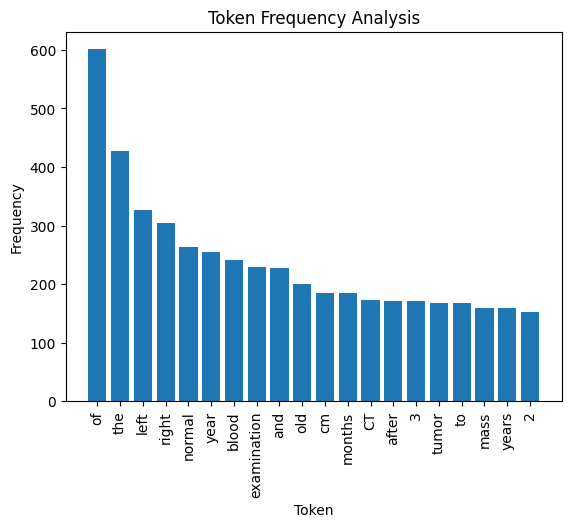

In [74]:
token_counts = get_token_counts(data, remove_stop_words=False)

# Sort the tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most common tokens and their counts
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Create the bar plot
plt.bar(top_tokens, top_counts)
plt.xticks(rotation=90)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Token Frequency Analysis')
plt.show()


### Annotated token frequency (After removing stop_words)

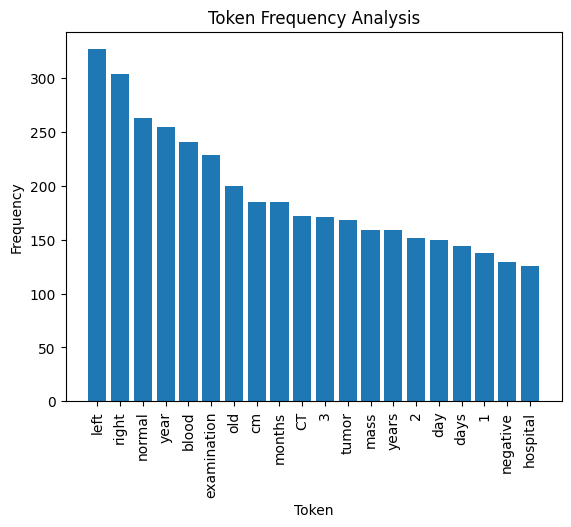

In [75]:

token_counts = get_token_counts(data)

# Sort the tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most common tokens and their counts
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Create the bar plot
plt.bar(top_tokens, top_counts)
plt.xticks(rotation=90)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Token Frequency Analysis')
plt.show()


### Collocation analysis

In [76]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Define the function to get collocations
def get_collocations(data):
    # Tokenize the text and filter out stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokenized_text = [word.lower() for file_id, file_data in data.items() for word in file_data['text'].split() if word.lower() not in stop_words]

    # Create a bigram collocation finder
    bigram_measures = BigramAssocMeasures()
    bigram_finder = BigramCollocationFinder.from_words(tokenized_text)

    # Filter out low frequency bigrams and get the top 10 collocations
    bigram_finder.apply_freq_filter(5)
    top_collocations = bigram_finder.nbest(bigram_measures.pmi, 10)

    return top_collocations
get_collocations(data)

[('ground', 'glass'),
 ('glasgow', 'coma'),
 ('lesser', 'curvature'),
 ('egfr', 'tki'),
 ('vena', 'cava'),
 ('bronchoalveolar', 'lavage'),
 ('glomerular', 'filtration'),
 ('muscularis', 'propria'),
 ('6-minute', 'walk'),
 ('alkaline', 'phosphatase')]

In [77]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

def get_collocations(data):
    collocations = []
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        annotated_tokens = []
        for annotation in annotations:
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens += annotated_text.split()

        finder = BigramCollocationFinder.from_words(annotated_tokens)
        bigram_measures = BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.raw_freq)
        collocations += scored

    return collocations
get_collocations(data)

[(('lower', 'right'), 0.01652892561983471),
 (('malignant', 'cells'), 0.01652892561983471),
 (('12', '×'), 0.008264462809917356),
 (('15', 'mm'), 0.008264462809917356),
 (('2%', 'size'), 0.008264462809917356),
 (('2008', '4'), 0.008264462809917356),
 (('24', 'year'), 0.008264462809917356),
 (('4', 'cm'), 0.008264462809917356),
 (('4', 'days'), 0.008264462809917356),
 (('6', 'months'), 0.008264462809917356),
 (('Abrikossoff', 'tumor'), 0.008264462809917356),
 (('CT', 'scan'), 0.008264462809917356),
 (('Cuban', 'cold'), 0.008264462809917356),
 (('Four', 'days'), 0.008264462809917356),
 (('May', '2008'), 0.008264462809917356),
 (('S100', 'positive'), 0.008264462809917356),
 (('admission.', 'histological'), 0.008264462809917356),
 (('after', 'discharge'), 0.008264462809917356),
 (('after', 'recovery'), 0.008264462809917356),
 (('after', 'the'), 0.008264462809917356),
 (('biopsy', 'mass'), 0.008264462809917356),
 (('bleeding', 'biopsy'), 0.008264462809917356),
 (('breathing', 'holidays'), 0

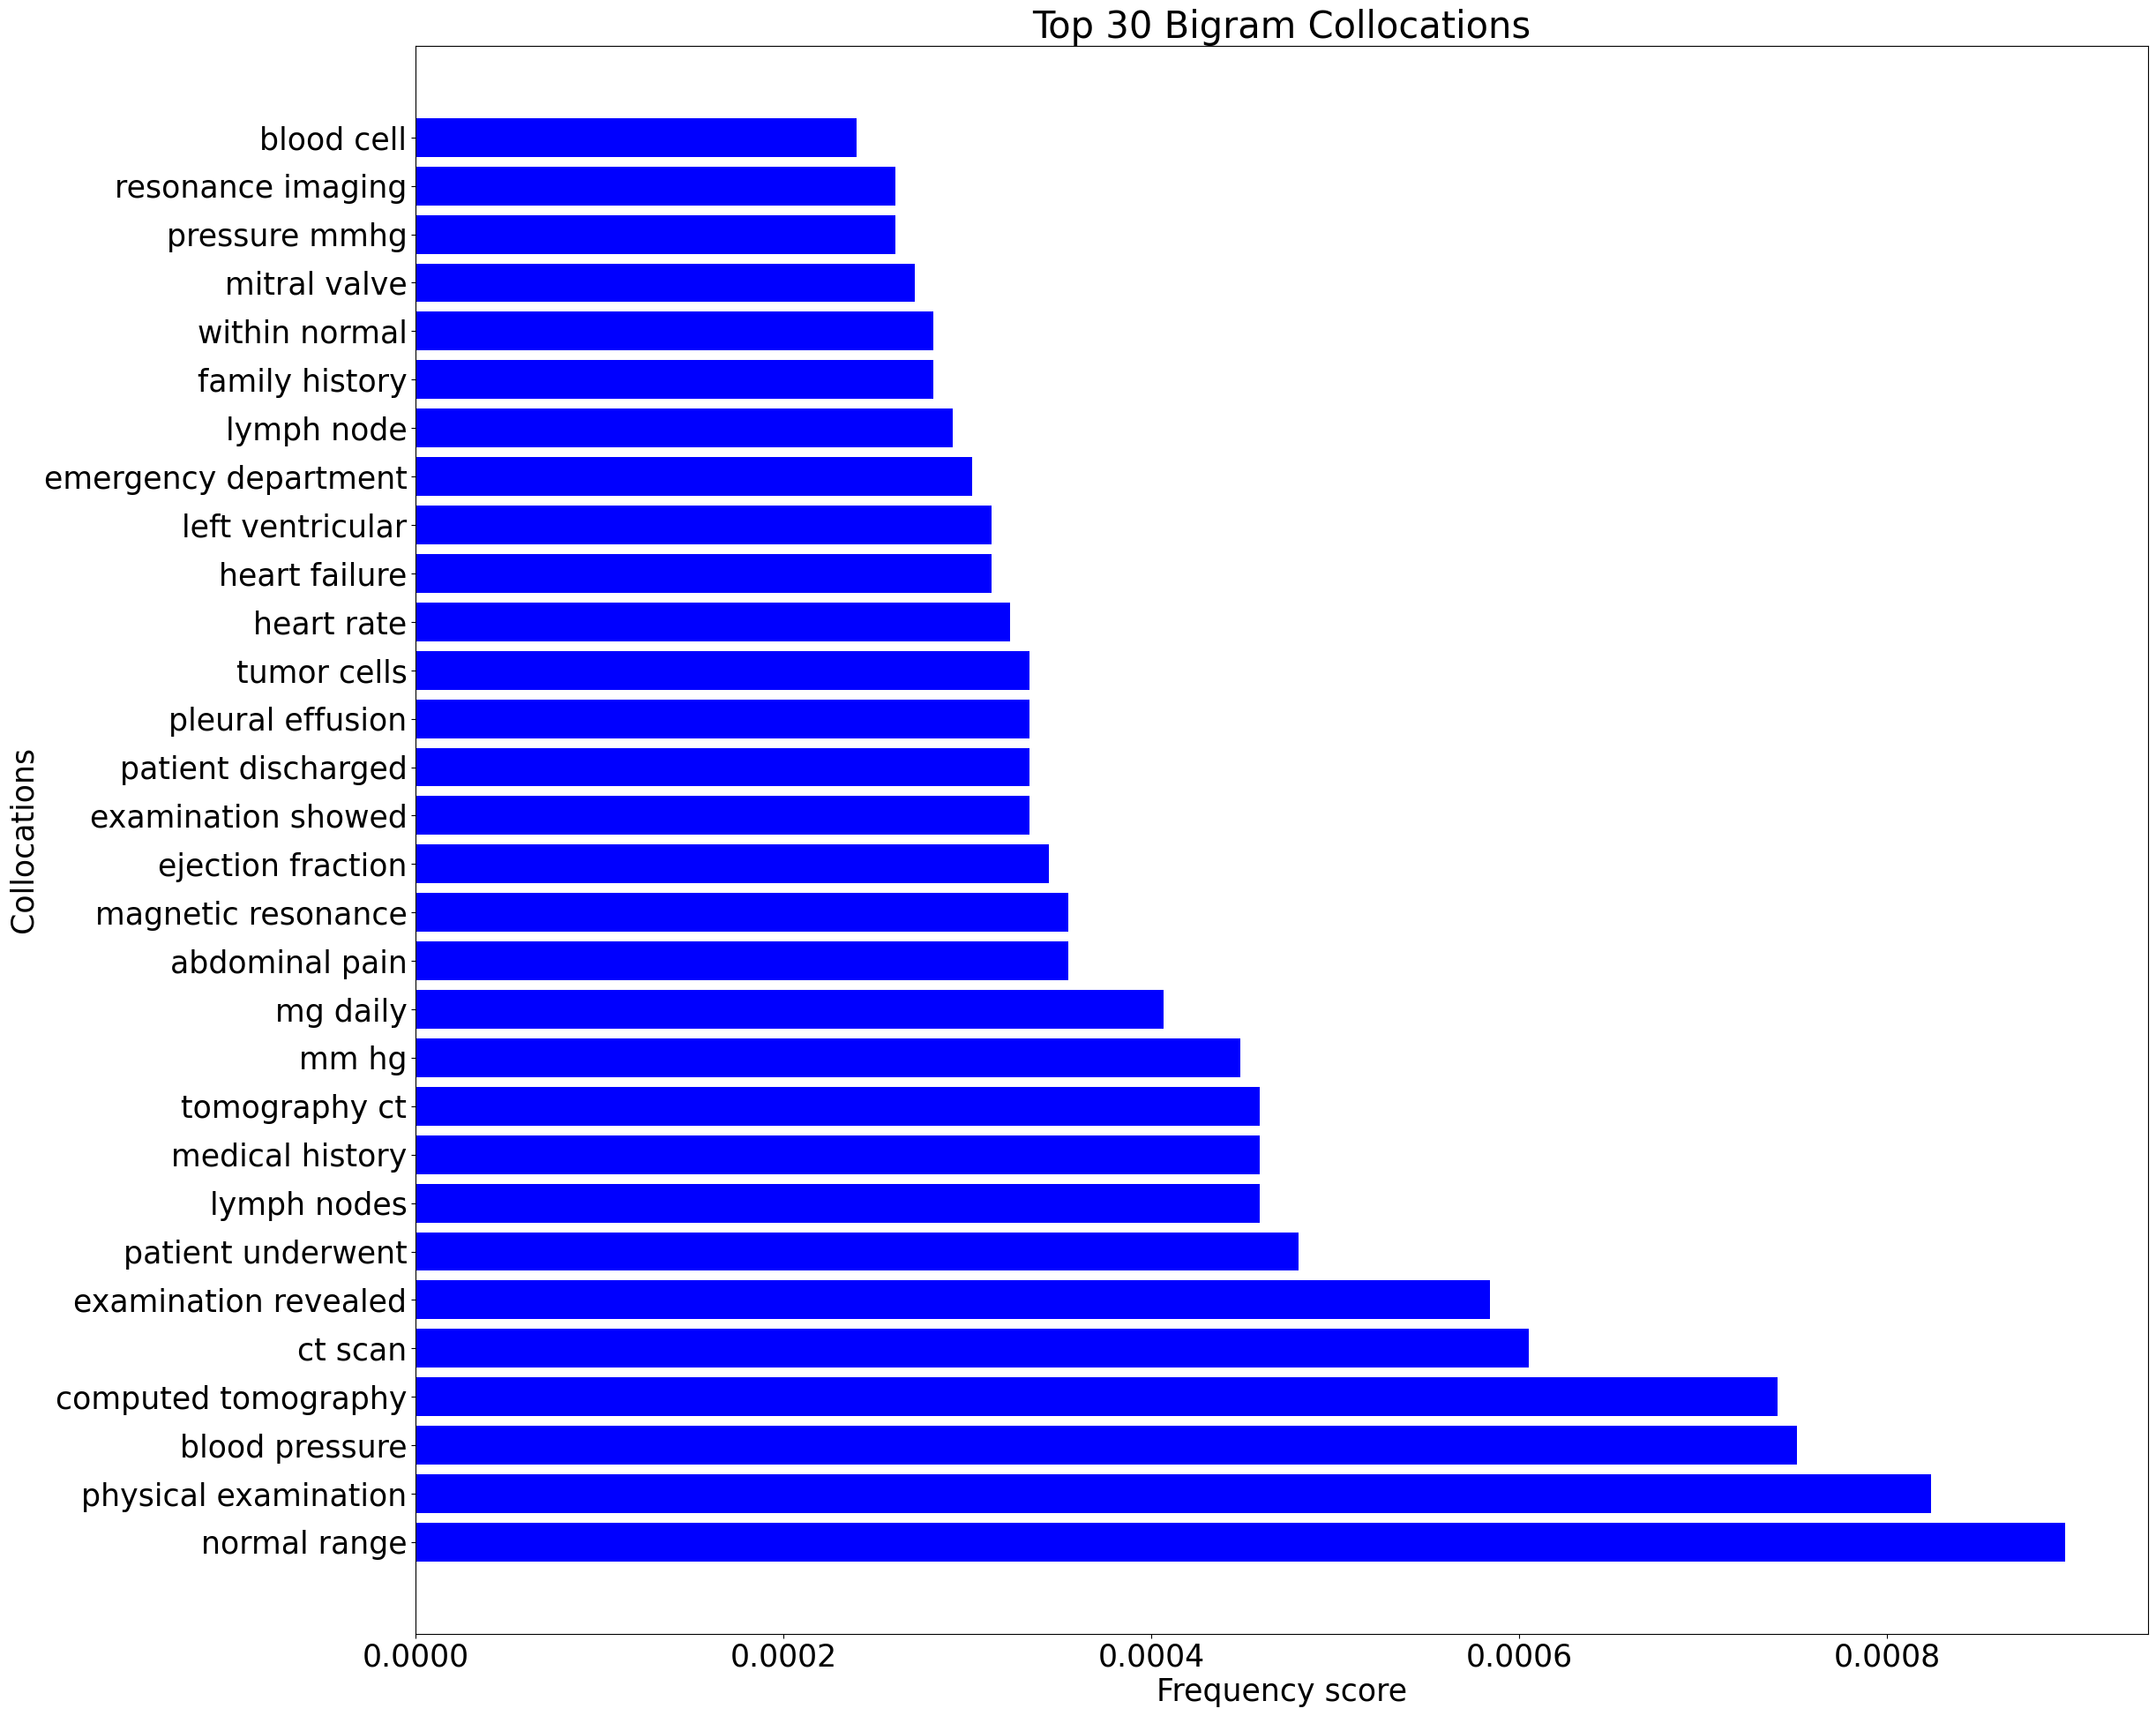

In [78]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

# Load stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

all_tokens = []

for doc_id, doc in data.items():
    contents = doc['text']
    # tokenize the text
    tokens = nltk.word_tokenize(contents.lower())
    # remove stop words and punctuation
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    all_tokens.extend(tokens)

# create bigrams
bigrams = list(nltk.bigrams(all_tokens))
# create a bigram collocation finder
finder = BigramCollocationFinder.from_documents(bigrams)
# apply a scoring metric to rank the collocations
scored = finder.score_ngrams(BigramAssocMeasures().raw_freq)
# get the top 30 collocations
collocations = [' '.join(collocation) for collocation, score in scored[:30]]

# create a pandas dataframe with the collocations and their frequency
collocations_freq = [score for collocation, score in scored[:30]]
collocations = [' '.join(collocation) for collocation, score in scored[:30]]
df = pd.DataFrame({'collocation': collocations, 'frequency': collocations_freq})

# plot the collocations as a bar chart
plt.figure(figsize=(25, 20))
plt.rcParams.update({'font.size': 25})
plt.barh(df['collocation'], df['frequency'], color='blue')
plt.title('Top 30 Bigram Collocations')
plt.ylabel('Collocations')
plt.xlabel('Frequency score')
plt.tight_layout()  # optional, to improve spacing

plt.show()



### Distribution of Entity types

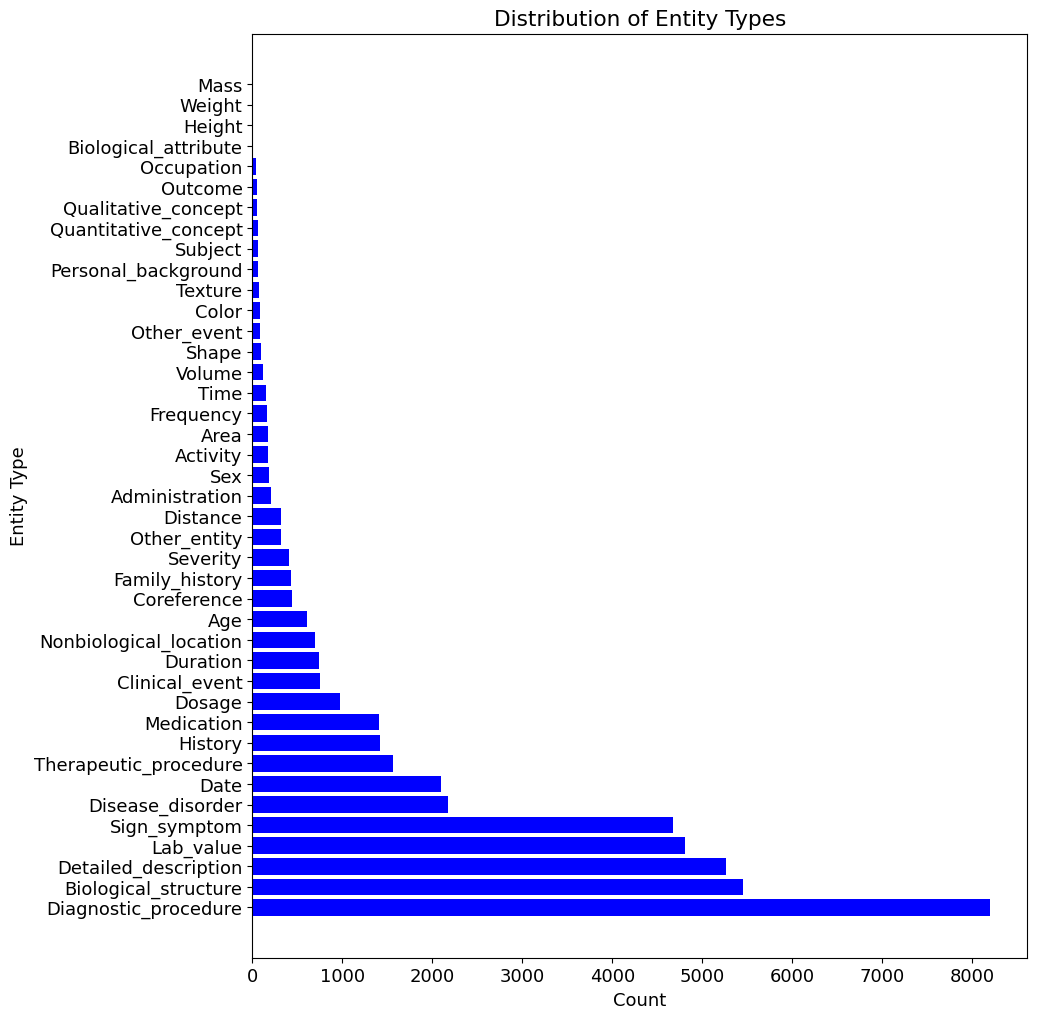

In [79]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# Create an empty dictionary to store entity types and their counts
entity_counts = {}

# Loop through each document in your data dictionary
for doc_id, doc in data.items():
    contents = doc['text']
    annotations = doc['annotations']

    # Create a Doc object from the text
    doc = nlp(contents)
    prev_end = -1
    # Add your custom annotations to the Doc object
    for ann in annotations:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
        
    # Loop through each entity in the parsed document
    for ent in doc.ents:
        # If the entity type is not in the entity_counts dictionary, add it with a count of 1
        if ent.label_ not in entity_counts:
            entity_counts[ent.label_] = 1
        # If the entity type is already in the entity_counts dictionary, increment its count by 1
        else:
            entity_counts[ent.label_] += 1        
            
# Convert the entity_counts dictionary to a pandas DataFrame for plotting
df = pd.DataFrame({'Entity Type': list(entity_counts.keys()), 'Count': list(entity_counts.values())})

# Sort the DataFrame by count in descending order
df = df.sort_values(by=['Count'], ascending=False)

# Plot the entity type counts as a bar chart
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(10, 12))
plt.barh(df['Entity Type'], df['Count'], color='blue')

plt.title('Distribution of Entity Types')
plt.ylabel('Entity Type')
plt.xlabel('Count')
plt.show()

### Analyzing the entity lengths, frequencies, and contexts.

In [80]:
# load the data
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# get the entity lengths
entity_lengths = []
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_lengths.append(ann['end'] - ann['start'])

# get the entity frequencies
entity_frequencies = Counter()
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_frequencies[ann['label']] += 1

# get the entity contexts
entity_contexts = {}
for doc_id in data:
    doc = nlp(data[doc_id]['text'])
    
    for ann in data[doc_id]['annotations']:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
    
    for ent in doc.ents:
        label = ent.label_
        start = ent.start_char
        end = ent.end_char
        context = doc[max(0, start-5):end+5].text
        if label not in entity_contexts:
            entity_contexts[label] = []
        entity_contexts[label].append(context)

# print the results
print('Entity lengths:')
print('  Min:', min(entity_lengths))
print('  Max:', max(entity_lengths))
print('  Mean:', sum(entity_lengths)/len(entity_lengths))
print('Entity frequencies:')
for label, freq in entity_frequencies.items():
    print('  {}: {}'.format(label, freq))
print('Entity contexts:')
for label, contexts in entity_contexts.items():
    print('  {}:'.format(label))
    for context in contexts[:3]:
        if context:
            print('    - {}'.format(context))


Entity lengths:
  Min: 1
  Max: 54
  Mean: 6.400996345283676
Entity frequencies:
  Age: 613
  History: 1846
  Sex: 191
  Clinical_event: 757
  Detailed_description: 5319
  Sign_symptom: 4814
  Date: 2112
  Duration: 756
  Biological_structure: 5488
  Personal_background: 73
  Severity: 415
  Texture: 77
  Coreference: 437
  Diagnostic_procedure: 8364
  Area: 174
  Disease_disorder: 2209
  Lab_value: 5005
  Therapeutic_procedure: 1601
  Distance: 325
  Medication: 1444
  Dosage: 991
  Shape: 94
  Administration: 205
  Nonbiological_location: 695
  Qualitative_concept: 56
  Frequency: 170
  Activity: 179
  Volume: 122
  Quantitative_concept: 65
  Outcome: 54
  Subject: 78
  Color: 82
  Other_event: 94
  Time: 169
  Family_history: 493
  Biological_attribute: 13
  Height: 8
  Mass: 4
  Occupation: 41
  Weight: 8
  Other_entity: 327
Entity contexts:
  Age:
    - -year-old non-smoking male patient presented with repeated hemoptysis in
    - -smoking male patient presented with repeated hemo

### Check for overlapping entities:

In [81]:
multi_label_words_count = 0
multi_label_files_count = 0
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] >= annotations[i+1]['start']:
            overlapping = True
            multi_label_words_count += 1
            # print(f"Overlap found between {annotations[i]} and {annotations[i+1]}")

    if overlapping:
        multi_label_files_count += 1
        
print(f"Total number of words with multi labels found is {multi_label_words_count}")
print(f"Total number of files with multi labelled words is {multi_label_files_count}")

Total number of words with multi labels found is 826
Total number of files with multi labelled words is 105


In [82]:
total_count = 0
overlapping_count_dict = {}
for doc_id in data:

    overlapping_count = 0
    
    text = data[doc_id]['text']
    
    annotations = data[doc_id]['annotations']
    
    for i in range(len(annotations)-1):
        label = annotations[i]['label']
        start = annotations[i]['start']
        end = annotations[i]['end']
        
        if annotations[i]['end'] > annotations[i+1]['start']:
            total_count += 1
            overlapping_count += 1
    overlapping_count_dict[doc_id] = overlapping_count

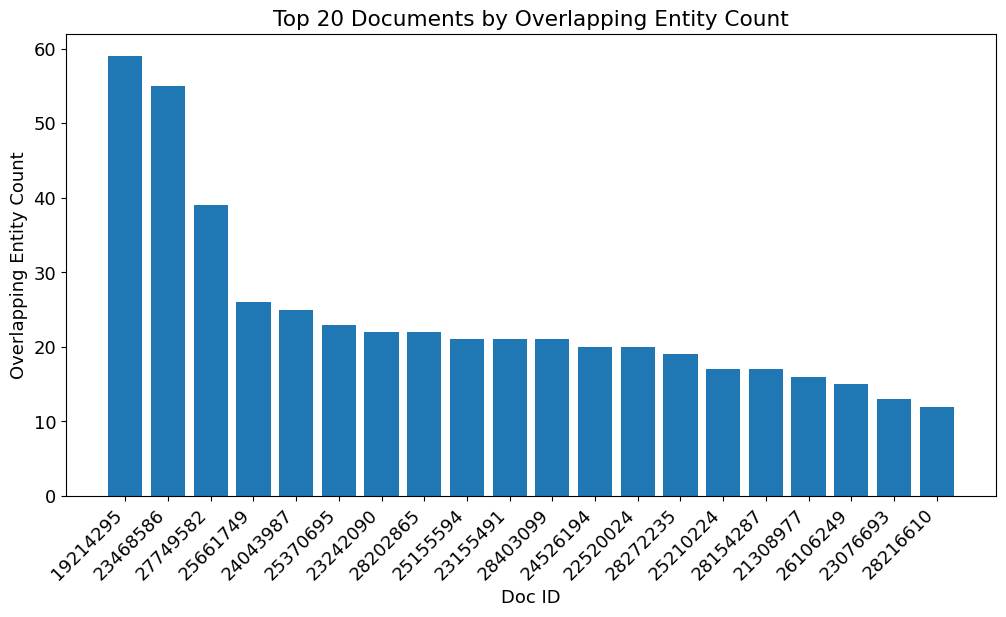

In [153]:
import matplotlib.pyplot as plt

sorted_dict = dict(sorted(overlapping_count_dict.items(), key=lambda item: item[1], reverse=True)[:20])
doc_ids = list(sorted_dict.keys())
overlapping_counts = list(sorted_dict.values())

fig, ax = plt.subplots(figsize=(12,6))


ax.set_xlabel('Doc ID')
ax.set_ylabel('Overlapping Entity Count')
ax.set_title('Top 20 Documents by Overlapping Entity Count')
ax.set_xticks(range(len(doc_ids)))  # set the tick locations
ax.set_xticklabels(doc_ids, rotation=45, ha='right')  # set the tick labels
ax.bar(doc_ids, overlapping_counts)
plt.show()



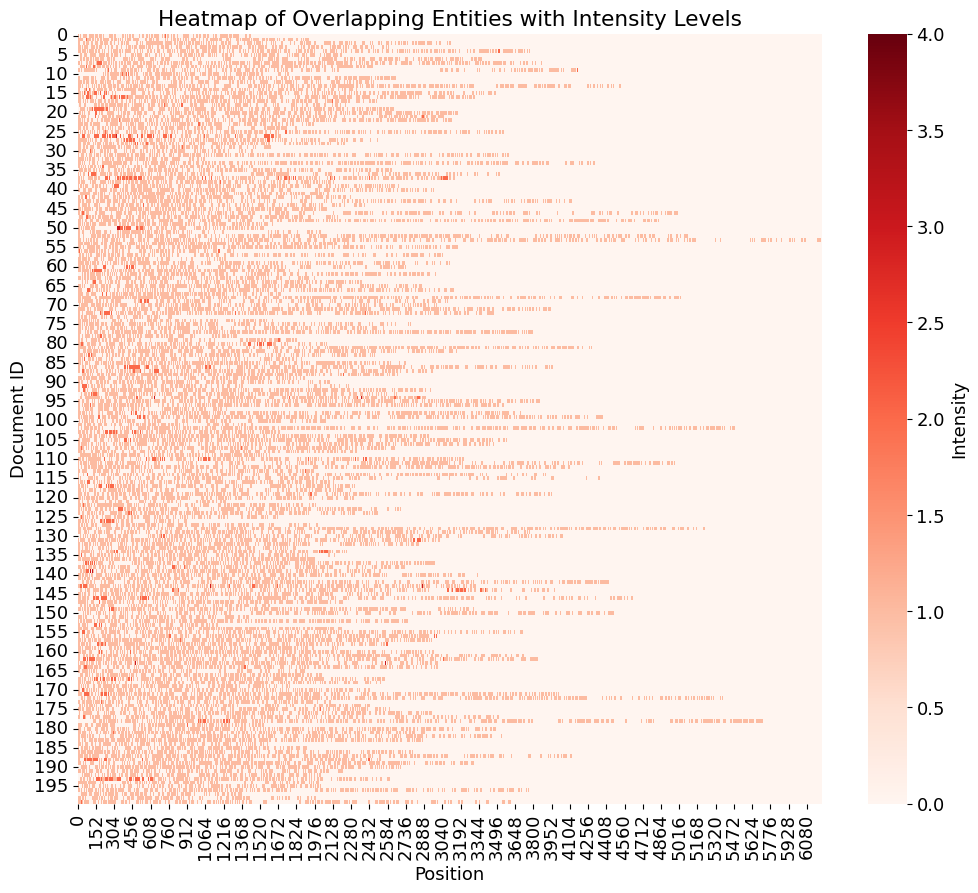

In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create the entity_ranges dictionary
entity_ranges = {}
max_end_of_text = 0

for doc_id in data:
    text = data[doc_id]['text']
    if len(text) > max_end_of_text:
        max_end_of_text = len(text)
        
    annotations = data[doc_id]['annotations']
    doc_entity_ranges = []
    for ann in annotations:
        start = ann['start']
        end = ann['end']
        doc_entity_ranges.append((start, end))
    entity_ranges[doc_id] = doc_entity_ranges

# create the heatmap with overlapping intensity levels
heatmap = np.zeros((len(entity_ranges), max_end_of_text))
row = 0
for doc_id, doc_entity_ranges in entity_ranges.items():
    for start, end in doc_entity_ranges:
        for i in range(start, end):
            heatmap[row][i] += 1
    row += 1
# plot the heatmap with Seaborn
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap, cmap='Reds', cbar_kws={'label': 'Intensity'})
ax.set_xlabel('Position')
ax.set_ylabel('Document ID')
ax.set_title('Heatmap of Overlapping Entities with Intensity Levels')

plt.show()


### Checking if subwords overlaps

Checking if there are any annotated start_end_range partially overlapping

In [28]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if word_1 != word_2:
                print(f"part of words overlaps: {word_1} {word_2}")
#                 print(f"labels: {file_id} {annotations[i]['label']} {annotations[i]['start']} {annotations[i]['end']}, {annotations[i+1]['label']} {annotations[i+1]['start']} {annotations[i+1]['end']}")

part of words overlaps: old old,
part of words overlaps: symmetry, symmetry
part of words overlaps: months months’
part of words overlaps: years years.
part of words overlaps: walking walking,
part of words overlaps: (LV) LV
part of words overlaps: hepatitis hepatitis,
part of words overlaps: long ong
part of words overlaps: insufficiency insufficiency,
part of words overlaps: IIA, IIA
part of words overlaps: T1bN1, T1bN1
part of words overlaps: bacteria bacteria,
part of words overlaps: diarrhoea, diarrhoea
part of words overlaps: intake intake,
part of words overlaps: drugs drugs,
part of words overlaps: tobacco tobacco,
part of words overlaps: pork, pork
part of words overlaps: consanguineous consanguineous,
part of words overlaps: output, output
part of words overlaps: dialysis, dialysis
part of words overlaps: intolerance, intolerance
part of words overlaps: palpitation, palpitation
part of words overlaps: GD GD,
part of words overlaps: smoking smoking,
part of words overlaps: sib

We could see that there are a lot of overlapped annotated tokens differs by a trailing punctuations.

It means for some tokens, duplicate annotations exists 
* one that doesn't include trailing puncutation 
* one that includes trailing punctuations

In general, it is recommended to remove trailing punctuation marks for Named Entity Recognition (NER) tasks. This is because trailing punctuation marks such as periods, commas, and question marks are often not part of the named entity and can lead to incorrect labeling.

data

In [28]:
# Count number of files starting and ending with punctuation
start_punct_count = 0
end_punct_count = 0
neither_punct_count = 0

# Loop through each file in the data dictionary
for file_id, file_data in data.items():

    for annotation in file_data['annotations']:
        
        # Get the annotated text
        annotated_text = file_data['text'][annotation['start']:annotation['end']]
        # Check if the first or last character of the annotated text is a punctuation character
        if annotated_text[0] in string.punctuation:
            start_punct_count += 1
        elif annotated_text[-1] in string.punctuation:
            end_punct_count += 1
        else:
            neither_punct_count += 1
            
# Print counts in table format
print('{:<25}{}'.format('Category', 'Count'))
print('-'*35)
print('{:<25}{}'.format('Starts with punctuation', start_punct_count))
print('{:<25}{}'.format('Ends with punctuation', end_punct_count))
print('{:<25}{}'.format('Neither', neither_punct_count))


Category                 Count
-----------------------------------
Starts with punctuation  158
Ends with punctuation    512
Neither                  45298


#### Removing Trailing Punctuation

In [29]:
def remove_trailing_punctuation(token):
    """
    Removes trailing punctuation from a token.

    Args:
        token (str): A string representing the token to be cleaned.

    Returns:
        str: The cleaned token with trailing punctuation removed.
    """
    while token and re.search(r'[^\w\s\']', token[-1]):
        token = token[:-1]
        
    return token

In [30]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if remove_trailing_punctuation(word_1) != remove_trailing_punctuation(word_2):
                print(f"doc_id: {file_id} words: {word_1} {word_2}", end=" | ")
                print(f"labels: {file_id} {annotations[i]['label']} {annotations[i]['start']} {annotations[i]['end']}, {annotations[i+1]['label']} {annotations[i+1]['start']} {annotations[i+1]['end']}")

doc_id: 23468586 words: (LV) LV | labels: 23468586 History 314 318, Disease_disorder 315 317
doc_id: 19214295 words: long ong | labels: 19214295 Detailed_description 424 428, History 425 428
doc_id: 27749582 words: (HBV) HBV | labels: 27749582 History 253 258, Detailed_description 254 257


Fixing "doc_id: 19214295 words: long ong | labels: 19214295 Detailed_description 424 428, History 425 428"

In [31]:
for annotation in data['19214295']['annotations']:
    if annotation['start'] == 425:
        annotation['start'] = 424

### Saving data dictionary to a json file

In [33]:
def create_json(preprocessed_data_dir, data):

    if os.path.exists(preprocessed_data_dir):
        # Delete the contents of the directory
        shutil.rmtree(preprocessed_data_dir)
    # Recreate the directory
    os.makedirs(preprocessed_data_dir)
    
    # Write the dictionary to a JSON file
    with open(os.path.join(preprocessed_data_dir, "annotated_data.json"), "w") as f:
        json.dump(data, f)

In [34]:
preprocessed_data_dir = "../data/annotated_json_data"
create_json(preprocessed_data_dir, data)